In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings

# load video data

In [2]:
# 3d config.yaml file path
# camera12_config_path = "/home/ws523/marmoset_tracking_DLCv2/marmoset_tracking_middle_camera_new_pos3_camera12-weikang-2022-09-20-3d/"

# 3d analyzed video path
camera12_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/20221015_Dodson_Scorch_camera12/"
camera23_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/20221015_Dodson_Scorch_camera23/"
# camera13_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/20221015_Dodson_Scorch_camera13/"

# h5 files for the analyzed videos
camera12_h5_file = camera12_analyzed_path + "20221015_Dodson_Scorch_weikang.h5"
camera23_h5_file = camera23_analyzed_path + "20221015_Dodson_Scorch_weikang.h5"
# camera13_h5_file = camera13_analyzed_path + "20221015_Dodson_Scorch_weikang.h5"

# h5 files for save 
camera12_h5_file_save = camera12_analyzed_path + "20221015_Dodson_Scorch_weikang.h5"
camera23_h5_file_save = camera23_analyzed_path + "20221015_Dodson_Scorch_weikang.h5"
# camera13_h5_file_save = camera13_analyzed_path + "20221015_Dodson_Scorch_weikang.h5"

# meta pickle data for the analyzed videos
camera12_metapickle_file = camera12_analyzed_path + "20221015_Dodson_Scorch_weikang_meta.pickle"
camera23_metapickle_file = camera23_analyzed_path + "20221015_Dodson_Scorch_weikang_meta.pickle"
# camera13_metapickle_file = camera13_analyzed_path + "20221015_Dodson_Scorch_weikang_meta.pickle"

# load data
camera12_metapickle_data = pd.read_pickle(camera12_metapickle_file)
camera23_metapickle_data = pd.read_pickle(camera23_metapickle_file)
# camera13_metapickle_data = pd.read_pickle(camera13_metapickle_file)

camera12_h5_data = pd.read_hdf(camera12_h5_file)
camera23_h5_data = pd.read_hdf(camera23_h5_file)
# camera13_h5_data = pd.read_hdf(camera13_h5_file)


In [3]:
# get the fps of the analyzed video
import cv2
video_cam1_file = camera12_analyzed_path + "20221015_Dodson_Scorch_camera-1.mp4"
cam = cv2.VideoCapture(video_cam1_file)
fps1 = cam.get(cv2.CAP_PROP_FPS)
video_cam2_file = camera12_analyzed_path + "20221015_Dodson_Scorch_camera-2.mp4"
cam = cv2.VideoCapture(video_cam2_file)
fps2 = cam.get(cv2.CAP_PROP_FPS)
fps = fps1
fps = 30
fps

30

In [4]:
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used
session_start_time = 27.90 # in second
session_start_frame = session_start_time * fps # fps is 30Hz

In [5]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
angle_thres = np.pi/18 # 10 degree

# analyze based on camera 1 and camera 2 

In [6]:
# analysis - camera 1 and 2
ncols = camera12_h5_data.shape[1]
nframes = camera12_h5_data.shape[0]
animal_names = []
body_parts = []
xyz_axis = []

for i in np.arange(0,ncols,1):
    animal_names.append(camera12_h5_data.columns[i][1])
    body_parts.append(camera12_h5_data.columns[i][2])
    xyz_axis.append(camera12_h5_data.columns[i][3])
  
    # fill in the nan data point
    data_point = camera12_h5_data.iloc[:,i]
    data_point_filled = data_point.interpolate(method='nearest',limit_direction='both')
    data_point_filled = data_point_filled.interpolate(method='linear',limit_direction='both')
    # smooth the data point   
    # data_point_filtered = data_point_filled.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
    #
    # camera12_h5_data.iloc[:,i] = data_point_filled
    
animal_names_unique = pd.unique(animal_names)
print(animal_names_unique)
body_parts_unique = pd.unique(body_parts)
print(body_parts_unique)
xyz_axis_unique = pd.unique(xyz_axis)
print(xyz_axis_unique)

# camera12_h5_data.to_hdf(camera12_h5_file_save, key = "camera12_h5_data")


['dodson' 'scorch']
['rightTuft' 'whiteBlaze' 'leftTuft' 'rightEye' 'leftEye' 'mouth']
['x' 'y' 'z']


In [7]:
# find the location of each body part
body_part_locs = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        ind = np.isin(animal_names,iname) & np.isin(body_parts,ibody)
        body_part_locs[(iname,ibody)] = camera12_h5_data.iloc[:,ind]  
        
        # remove the outlier 
        for iaxis in np.arange(0,3,1):
            # loc_std = np.std(body_part_locs[(iname,ibody)])[iaxis]
            # loc_mean = pd.DataFrame.mean(body_part_locs[(iname,ibody)])[iaxis]
            # ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>loc_mean+3*loc_std) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<loc_mean-3*loc_std)
            # body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            q1 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.25)
            q3 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.75)
            thres1 = q1 - 1.5*abs(q3-q1)
            thres2 = q3 + 1.5*abs(q3-q1)
            ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>thres2) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<thres1)
            body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            
body_part_locs_camera12 = body_part_locs

In [8]:
warnings.filterwarnings('ignore')
eye_direction_camera12 = {}
eye_contact_or_not_camera12 = {}
look_at_face_or_not_camera12 = {}
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,nframes,1):
        lefteye_loc = body_part_locs[(iname,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc = body_part_locs[(iname,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc = body_part_locs[(iname,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc = body_part_locs[(iname,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc = body_part_locs[(iname,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc = body_part_locs[(iname,'mouth')].iloc[iframe,:].to_numpy()
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs[(iname_other,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc_other = body_part_locs[(iname_other,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc_other = body_part_locs[(iname_other,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc_other = body_part_locs[(iname_other,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc_other = body_part_locs[(iname_other,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc_other = body_part_locs[(iname_other,'mouth')].iloc[iframe,:].to_numpy()
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_camera12[(iname)] = eye_dir_frames
    eye_contact_or_not_camera12[(iname)] = eye_contact_frames
    look_at_face_or_not_camera12[(iname)] = look_at_face_frames
        

In [9]:
eye_direction_camera12['time_in_second'] = np.arange(0,np.shape(eye_direction_camera12['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_camera12['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_camera12['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_camera12['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_camera12['dodson'])[0],1)/30 - session_start_time

In [10]:
# sanity check
np.where(np.array(eye_contact_or_not_camera12['scorch'])==1)

(array([ 1586,  5548,  6298,  7296,  9626, 10600, 10609, 10611, 14024,
        14223, 14530, 14752, 14753, 15051, 15160, 15781, 16006, 16282,
        16283, 16802, 16807, 16844, 17122, 17123, 17133, 17139, 17140,
        17246, 17543, 17983, 17989, 17990, 17991, 18013, 18199, 18204,
        18220, 18776, 18889, 18891, 18894, 18896, 19131, 19133, 19134,
        19210, 19639, 19798, 20460, 20461, 20462, 20465, 20519, 21222,
        21224]),)

In [11]:
# sanity check
np.where(np.array(eye_contact_or_not_camera12['dodson'])==1)

(array([ 2255, 15417, 18933, 18934]),)

# analyze based on camera 2 and camera 3 

In [12]:
# analysis - camera 2 and 3
ncols = camera23_h5_data.shape[1]
nframes = camera23_h5_data.shape[0]
animal_names = []
body_parts = []
xyz_axis = []

for i in np.arange(0,ncols,1):
    animal_names.append(camera23_h5_data.columns[i][1])
    body_parts.append(camera23_h5_data.columns[i][2])
    xyz_axis.append(camera23_h5_data.columns[i][3])
  
    # fill in the nan data point
    data_point = camera23_h5_data.iloc[:,i]
    data_point_filled = data_point.interpolate(method='nearest',limit_direction='both')
    data_point_filled = data_point_filled.interpolate(method='linear',limit_direction='both')
    # smooth the data point   
    # data_point_filtered = data_point_filled.rolling(window=5, win_type='gaussian', center=True).mean(std=0.5)
    #
    # camera23_h5_data.iloc[:,i] = data_point_filled
    
animal_names_unique = pd.unique(animal_names)
print(animal_names_unique)
body_parts_unique = pd.unique(body_parts)
print(body_parts_unique)

# camera23_h5_data.to_hdf(camera23_h5_file_save, key = "camera23_h5_data")


['dodson' 'scorch']
['rightTuft' 'whiteBlaze' 'leftTuft' 'rightEye' 'leftEye' 'mouth']


In [13]:
# find the location of each body part
body_part_locs = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        ind = np.isin(animal_names,iname) & np.isin(body_parts,ibody)
        body_part_locs[(iname,ibody)] = camera23_h5_data.iloc[:,ind]    
        
        # remove the outlier 
        for iaxis in np.arange(0,3,1):
            # loc_std = np.std(body_part_locs[(iname,ibody)])[iaxis]
            # loc_mean = pd.DataFrame.mean(body_part_locs[(iname,ibody)])[iaxis]
            # ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>loc_mean+3*loc_std) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<loc_mean-3*loc_std)
            # body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            q1 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.25)
            q3 = np.nanquantile(body_part_locs[(iname,ibody)].iloc[:,iaxis],0.75)
            thres1 = q1 - 1.5*abs(q3-q1)
            thres2 = q3 + 1.5*abs(q3-q1)
            ind = (body_part_locs[(iname,ibody)].iloc[:,iaxis]>thres2) | (body_part_locs[(iname,ibody)].iloc[:,iaxis]<thres1)
            body_part_locs[(iname,ibody)].iloc[:,iaxis][ind] = np.nan
            
body_part_locs_camera23 = body_part_locs

In [14]:
warnings.filterwarnings('ignore')
eye_direction_camera23 = {}
eye_contact_or_not_camera23 = {}
look_at_face_or_not_camera23 = {}
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,nframes,1):
        lefteye_loc = body_part_locs[(iname,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc = body_part_locs[(iname,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc = body_part_locs[(iname,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc = body_part_locs[(iname,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc = body_part_locs[(iname,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc = body_part_locs[(iname,'mouth')].iloc[iframe,:].to_numpy()
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs[(iname_other,'leftEye')].iloc[iframe,:].to_numpy()
        righteye_loc_other = body_part_locs[(iname_other,'rightEye')].iloc[iframe,:].to_numpy()
        lefttuft_loc_other = body_part_locs[(iname_other,'leftTuft')].iloc[iframe,:].to_numpy()
        righttuft_loc_other = body_part_locs[(iname_other,'rightTuft')].iloc[iframe,:].to_numpy()
        whiblz_loc_other = body_part_locs[(iname_other,'whiteBlaze')].iloc[iframe,:].to_numpy()
        mouth_loc_other = body_part_locs[(iname_other,'mouth')].iloc[iframe,:].to_numpy()
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_camera23[(iname)] = eye_dir_frames
    eye_contact_or_not_camera23[(iname)] = eye_contact_frames
    look_at_face_or_not_camera23[(iname)] = look_at_face_frames
        

In [15]:
eye_direction_camera23['time_in_second'] = np.arange(0,np.shape(eye_direction_camera23['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_camera23['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_camera23['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_camera23['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_camera23['dodson'])[0],1)/30 - session_start_time

In [16]:
# sanity check
np.where(np.array(eye_contact_or_not_camera23['scorch'])==1)

(array([], dtype=int64),)

In [17]:
# sanity check
np.where(np.array(eye_contact_or_not_camera23['dodson'])==1)

(array([ 1638,  1639,  1640,  1641,  1642,  1824,  1825,  1826,  2127,
         2128, 10120, 10121, 10126, 10127, 13334, 13335, 13336, 13354,
        13432, 13433, 13434, 13436, 13437, 13438, 13439, 13440, 13441,
        13442, 13443, 13444, 15333, 15334, 15338, 15339, 15340, 16247,
        20156, 20245, 20246, 20248, 20249, 20253, 20254, 20255, 20256,
        20257, 20258, 20259, 20260, 20261]),)

# examine the relationship between camera pairs
## make the 3d space aligned with each pair

In [18]:
# sanity check 
xxx = body_part_locs_camera23[('dodson','leftEye')].iloc[:,0]
yyy = body_part_locs_camera12[('dodson','leftEye')].iloc[:,0]

In [19]:
min_length = np.min([np.shape(xxx)[0],np.shape(yyy)[0]])
xxx = xxx[np.arange(0,min_length,1)]
yyy = yyy[np.arange(0,min_length,1)]

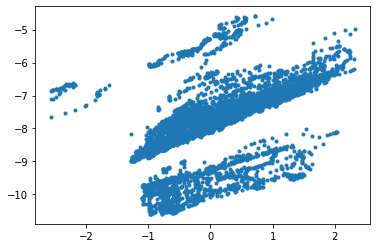

In [20]:
plt.plot(xxx,yyy,'.')

In [21]:
# try the rotation on all possible pairs
RR_sum = {}
tt_sum = {}
err_sum = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        xxx = body_part_locs_camera23[(iname,ibody)]
        yyy = body_part_locs_camera12[(iname,ibody)]
        min_lengh = np.min([xxx.shape[0],yyy.shape[0]])
        
        xxx = xxx.loc[np.arange(0,min_length,1),:]
        yyy = yyy.loc[np.arange(0,min_length,1),:]     
        
        ind_good = (~np.isnan(xxx.iloc[:,0]) & ~np.isnan(xxx.iloc[:,1]) & ~np.isnan(xxx.iloc[:,2])) & (~np.isnan(yyy.iloc[:,0]) & ~np.isnan(yyy.iloc[:,1]) & ~np.isnan(yyy.iloc[:,2])) 
        xxx_values = pd.DataFrame.transpose(xxx.loc[ind_good,:]).values
        yyy_values = pd.DataFrame.transpose(yyy.loc[ind_good,:]).values
        
        xxx_centroid = np.dot(np.mean(xxx_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
        yyy_centroid = np.dot(np.mean(yyy_values,axis = 1).reshape(3,1), np.ones((1,np.shape(xxx_values)[1])))
        HH = np.dot((xxx_values - xxx_centroid), np.transpose(yyy_values - yyy_centroid))
        u, s, vh = np.linalg.svd(HH, full_matrices=True)
        RR = np.dot(np.transpose(vh),np.transpose(u))
        tt= yyy_centroid - np.dot(RR,xxx_centroid)
        tt = tt[:,1].reshape(3,1)
        
        RR_sum[(iname,ibody)] = RR
        tt_sum[(iname,ibody)] = tt
        err_sum[(iname,ibody)] = np.sum(np.square(yyy_values - (np.dot(RR,xxx_values)+np.dot(tt, np.ones((1,np.shape(xxx_values)[1]))))))

RR = RR_sum[min(err_sum, key=err_sum.get)]
tt = tt_sum[min(err_sum, key=err_sum.get)]


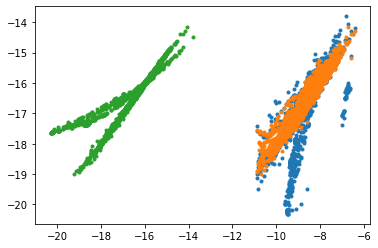

In [22]:
# sanity check
xxx_plot = np.transpose(body_part_locs_camera23[('scorch','leftTuft')].loc[np.arange(0,min_length,1),:].values)
yyy_plot = np.transpose(body_part_locs_camera12[('scorch','leftTuft')].loc[np.arange(0,min_length,1),:].values)
yyy_change = np.dot(RR,xxx_plot)
tt_change = np.dot(tt, np.ones((1,np.shape(xxx_plot)[1])))
yyy_change = np.dot(RR,xxx_plot) + tt_change
plt.plot(xxx_plot[0,:],yyy_plot[0,:],'.')
plt.plot(xxx_plot[0,:],yyy_change[0,:],'.')
plt.plot(yyy_plot[0,:],yyy_change[0,:],'.')

## merge the bhv from the two pairs of camera and redo the analysis

In [23]:
# merge the two pairs of cameras
body_part_locs_merge = {}
for iname in animal_names_unique:
    for ibody in body_parts_unique:
        RR = RR_sum[(iname,ibody)]
        tt = tt_sum[(iname,ibody)]
        body_part_x = np.transpose(body_part_locs_camera23[(iname,ibody)].loc[np.arange(0,min_length,1),:])
        body_part_project = np.transpose(np.dot(RR,body_part_x) + np.dot(tt, np.ones((1,np.shape(body_part_x)[1]))))
        body_part_origin = body_part_locs_camera12[(iname,ibody)].loc[np.arange(0,min_length,1),:].values
        body_part_origin[np.sum(np.isnan(body_part_origin),axis=1)>0,:] = body_part_project[np.sum(np.isnan(body_part_origin),axis=1)>0,:]

        body_part_locs_merge[(iname,ibody)] = body_part_origin
        

In [24]:
warnings.filterwarnings('ignore')
eye_direction_merge = {}
eye_contact_or_not_merge = {}
look_at_face_or_not_merge = {}
for iname in animal_names_unique:
    eye_dir_frames = []
    eye_contact_frames = []
    look_at_face_frames = []
    for iframe in np.arange(0,min_length,1):
        lefteye_loc = body_part_locs_merge[(iname,'leftEye')][iframe,:]
        righteye_loc = body_part_locs_merge[(iname,'rightEye')][iframe,:]
        lefttuft_loc = body_part_locs_merge[(iname,'leftTuft')][iframe,:]
        righttuft_loc = body_part_locs_merge[(iname,'rightTuft')][iframe,:]
        whiblz_loc = body_part_locs_merge[(iname,'whiteBlaze')][iframe,:]
        mouth_loc = body_part_locs_merge[(iname,'mouth')][iframe,:]
        
        Vect1 = lefteye_loc - righteye_loc
        Vect2 = whiblz_loc - mouth_loc
        Vect3 = lefttuft_loc - lefteye_loc
        Vect4 = righttuft_loc - righteye_loc
        
        try:       
            Vect1 = Vect1 / scipy.linalg.norm(Vect1)
            Vect2 = Vect2 / scipy.linalg.norm(Vect2) 
        except:
            Vect1 = Vect1
            Vect2 = Vect2
        eyesight_dir = np.cross(Vect1, Vect2)
        
        if ((np.dot(eyesight_dir, Vect3)>0) | (np.dot(eyesight_dir, Vect4)>0)):
            eyesight_dir = -eyesight_dir
        
        eye_dir_frames.append(eyesight_dir)
        
        
        # examine whether this animal is looking at the other's eyes or face
        if (iname == animal_names_unique[0]): 
            iname_other = animal_names_unique[1]
        elif (iname == animal_names_unique[1]): 
            iname_other = animal_names_unique[0]
            
        lefteye_loc_other = body_part_locs_merge[(iname_other,'leftEye')][iframe,:]
        righteye_loc_other = body_part_locs_merge[(iname_other,'rightEye')][iframe,:]
        lefttuft_loc_other = body_part_locs_merge[(iname_other,'leftTuft')][iframe,:]
        righttuft_loc_other = body_part_locs_merge[(iname_other,'rightTuft')][iframe,:]
        whiblz_loc_other = body_part_locs_merge[(iname_other,'whiteBlaze')][iframe,:]
        mouth_loc_other = body_part_locs_merge[(iname_other,'mouth')][iframe,:]
        
        # where left eye is looking
        # vector between body part
        vect1_lefteye = lefteye_loc_other - lefteye_loc
        vect2_lefteye = righteye_loc_other - lefteye_loc
        vect3_lefteye = lefttuft_loc_other - lefteye_loc
        vect4_lefteye = righttuft_loc_other - lefteye_loc
        vect5_lefteye = whiblz_loc_other - lefteye_loc
        vect6_lefteye = mouth_loc_other - lefteye_loc
        # angle between body part vector and eyesight direction
        angle1_lefteye =  np.sign(np.dot(eyesight_dir,vect1_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_lefteye/np.linalg.norm(vect1_lefteye)), -1.0, 1.0))       
        angle2_lefteye =  np.sign(np.dot(eyesight_dir,vect2_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_lefteye/np.linalg.norm(vect2_lefteye)), -1.0, 1.0))
        angle3_lefteye =  np.sign(np.dot(eyesight_dir,vect3_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_lefteye/np.linalg.norm(vect3_lefteye)), -1.0, 1.0))
        angle4_lefteye =  np.sign(np.dot(eyesight_dir,vect4_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_lefteye/np.linalg.norm(vect4_lefteye)), -1.0, 1.0))
        angle5_lefteye =  np.sign(np.dot(eyesight_dir,vect5_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_lefteye/np.linalg.norm(vect5_lefteye)), -1.0, 1.0))
        angle6_lefteye =  np.sign(np.dot(eyesight_dir,vect6_lefteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_lefteye/np.linalg.norm(vect6_lefteye)), -1.0, 1.0))
        
        # where right eye is looking
        # vector between body part
        vect1_righteye = lefteye_loc_other - righteye_loc
        vect2_righteye = righteye_loc_other - righteye_loc
        vect3_righteye = lefttuft_loc_other - righteye_loc
        vect4_righteye = righttuft_loc_other - righteye_loc
        vect5_righteye = whiblz_loc_other - righteye_loc
        vect6_righteye = mouth_loc_other - righteye_loc
        # angle between body part vector and eyesight direction
        angle1_righteye =  np.sign(np.dot(eyesight_dir,vect1_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect1_righteye/np.linalg.norm(vect1_righteye)), -1.0, 1.0))       
        angle2_righteye =  np.sign(np.dot(eyesight_dir,vect2_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect2_righteye/np.linalg.norm(vect2_righteye)), -1.0, 1.0))
        angle3_righteye =  np.sign(np.dot(eyesight_dir,vect3_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect3_righteye/np.linalg.norm(vect3_righteye)), -1.0, 1.0))
        angle4_righteye =  np.sign(np.dot(eyesight_dir,vect4_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect4_righteye/np.linalg.norm(vect4_righteye)), -1.0, 1.0))
        angle5_righteye =  np.sign(np.dot(eyesight_dir,vect5_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect5_righteye/np.linalg.norm(vect5_righteye)), -1.0, 1.0))
        angle6_righteye =  np.sign(np.dot(eyesight_dir,vect6_righteye))*np.arccos(np.clip(np.dot(eyesight_dir/np.linalg.norm(eyesight_dir), vect6_righteye/np.linalg.norm(vect6_righteye)), -1.0, 1.0))
        
        lefteye_contact_thres = ((angle1_lefteye>0)&(angle1_lefteye<angle_thres))|((angle2_lefteye>0)&(angle2_lefteye<angle_thres))
        lefteye_lookface_thres = ((angle3_lefteye>0)&(angle3_lefteye<angle_thres))|((angle4_lefteye>0)&(angle4_lefteye<angle_thres))|((angle5_lefteye>0)&(angle5_lefteye<angle_thres))|((angle6_lefteye>0)&(angle6_lefteye<angle_thres))
        righteye_contact_thres = ((angle1_righteye>0)&(angle1_righteye<angle_thres))|((angle2_righteye>0)&(angle2_righteye<angle_thres))
        righteye_lookface_thres = ((angle3_righteye>0)&(angle3_righteye<angle_thres))|((angle4_righteye>0)&(angle4_righteye<angle_thres))|((angle5_righteye>0)&(angle5_righteye<angle_thres))|((angle6_righteye>0)&(angle6_righteye<angle_thres))
        
        eye_contact_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres))
        look_at_face_frames.append(np.int(lefteye_contact_thres|righteye_contact_thres|lefteye_lookface_thres|righteye_lookface_thres))
        
    # save to the summarized data
    eye_direction_merge[(iname)] = eye_dir_frames
    eye_contact_or_not_merge[(iname)] = eye_contact_frames
    look_at_face_or_not_merge[(iname)] = look_at_face_frames
        

In [25]:
eye_direction_merge['time_in_second'] = np.arange(0,np.shape(eye_direction_merge['dodson'])[0],1)/30 - session_start_time
eye_contact_or_not_merge['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_merge['dodson'])[0],1)/30 - session_start_time
look_at_face_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_merge['dodson'])[0],1)/30 - session_start_time

## load behavioral results

In [26]:
# load behavioral results
bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/20221015_Dodson_Scorch/"
trial_record_json = bhv_data_path + "20221015_Dodson_Scorch_TrialRecord_1.json"
bhv_data_json = bhv_data_path + "20221015_Dodson_Scorch_bhv_data_1.json"
session_info_json = bhv_data_path + "20221015_Dodson_Scorch_session_info_1.json"

trial_record = pd.read_json(trial_record_json)
bhv_data = pd.read_json(bhv_data_json)
session_info = pd.read_json(session_info_json)

In [27]:
animal1 = session_info['lever1_animal'][0].lower()
animal2 = session_info['lever2_animal'][0].lower()
animal1

'dodson'

In [28]:
# clean up the trial_record
warnings.filterwarnings('ignore')
trial_record_clean = pd.DataFrame(columns=trial_record.columns)
for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
    # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
    trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
trial_record_clean = trial_record_clean.reset_index(drop = True)

In [29]:
# change bhv_data time to the absolute time
time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
    ind = bhv_data["trial_number"]==itrial+1
    new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
    time_points_new["time_points_new"][ind] = new_time_itrial
bhv_data["time_points"] = time_points_new["time_points_new"]

## plot behavioral results (with camera pair merged) and eye contact results

In [30]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_merge[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_merge[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_merge["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_merge[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_merge[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_merge["time_in_second"][ind_eyecontact2]

# calculate the oneway gaze or mutual gaze
animal1_gaze = np.round(np.concatenate((time_point_eyecontact1,time_point_lookatotherface1)),1)
animal1_gaze = np.unique(np.sort(animal1_gaze))
animal2_gaze = np.round(np.concatenate((time_point_eyecontact2,time_point_lookatotherface2)),1)
animal2_gaze = np.unique(np.sort(animal2_gaze))

ngaze1 = len(animal1_gaze)
ngaze2 = len(animal2_gaze)
oneway_gaze1 = []
oneway_gaze2 = []
mutual_gaze1 = []
mutual_gaze2 = []
# 
for igaze1 in np.arange(0, ngaze1, 1):
    for igaze2 in np.arange(0,ngaze2,1):
        if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
            mutual_gaze1.append(animal1_gaze[igaze1])
            mutual_gaze2.append(animal2_gaze[igaze2])
mutual_gaze1 = np.unique(mutual_gaze1)   
mutual_gaze2 = np.unique(mutual_gaze2)
oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]

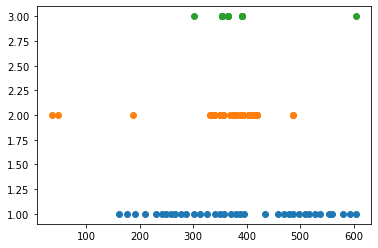

In [31]:
time_point_pull1 = np.round(time_point_pull1,2)
ind_plot = time_point_pull1 < 720
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(oneway_gaze1, np.ones(np.shape(oneway_gaze1)[0])*2,'o')
plt.plot(mutual_gaze1, np.ones(np.shape(mutual_gaze1)[0])*3,'o')

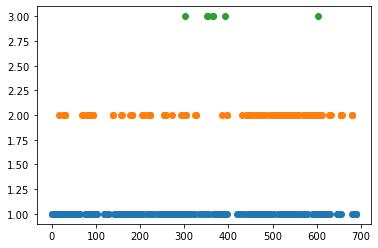

In [32]:
time_point_pull2 = np.round(time_point_pull2,2)
ind_plot = time_point_pull2 < 720
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(oneway_gaze2, np.ones(np.shape(oneway_gaze2)[0])*2,'o')
plt.plot(mutual_gaze2, np.ones(np.shape(mutual_gaze2)[0])*3,'o')

In [33]:
(mutual_gaze1+session_start_time)/60

array([ 5.49166667,  6.34833333,  6.35666667,  6.36      ,  6.36166667,
        6.54666667,  6.54833333,  6.55833333,  6.995     ,  6.99666667,
        6.99833333, 10.51833333])

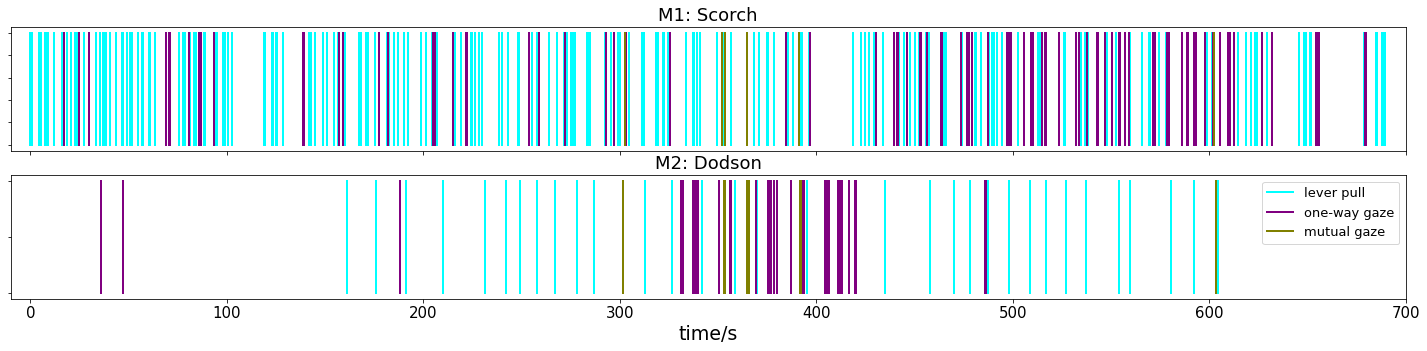

In [34]:
fig, axs = plt.subplots(2,1)
fig.set_figheight(5)
fig.set_figwidth(25)
# plot for animal 1
ind_plot = time_point_pull1 < 720
#for itime in np.arange(0,720,1):
#    plt.plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.5))
for itime in time_point_pull1[ind_plot]:
    line1, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.0,1.0,1.0),label = 'lever pull')
for itime in oneway_gaze1:
    line2, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.0,0.5),label = 'one-way gaze')    
for itime in mutual_gaze1:
    line3, = axs[1].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.0),label = 'mutual gaze')    
axs[1].set_title("M2: Dodson",fontsize = 18)
axs[1].set_xlim([-10,700])
axs[1].set_xlabel("time/s",fontsize = 19)
axs[1].set_yticklabels("")
axs[1].legend(handles=[line1,line2,line3], fontsize = 13)
axs[1].tick_params(labelsize = 15)

# plot for animal 2
ind_plot = time_point_pull2 < 720
#for itime in np.arange(0,720,1):
#    plt.plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.5))
for itime in time_point_pull2[ind_plot]:
    line1, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.0,1.0,1.0))
for itime in oneway_gaze2:
    line2, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.0,0.5))    
for itime in mutual_gaze2:
    line3, = axs[0].plot([itime,itime],[0,1],linewidth = 2.0,color=(0.5,0.5,0.0))    
axs[0].set_title("M1: Scorch",fontsize = 18)
axs[0].set_xlim([-10,700])
axs[0].set_xlabel("")
axs[0].set_xticklabels("")
axs[0].set_yticklabels("")

plt.savefig("20221015_DS_pattern.png")


## train the dynamic bayesian network

In [35]:
import numpy as np
import pandas as pd
from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
import networkx as nx

# example data
data = pd.DataFrame(np.random.randint(low=0, high=2, size=(5000, 4)), columns=['A', 'B', 'C', 'D'])
model = BayesianModel([('A', 'B'), ('A', 'C'), ('D', 'C'), ('B', 'D')])
model = DBN(
    [
        (("A", 0), ("B", 0)),
        (("A", 0), ("C", 0)),
        (("B", 0), ("D", 0)),
        (("C", 0), ("D", 0)),
        (("A", 0), ("A", 1)),
        (("B", 0), ("B", 1)),
        (("C", 0), ("C", 1)),
        (("D", 0), ("D", 1)),
    ]
)
data = np.random.randint(low=0, high=2, size=(1000, 20))
colnames = []
for t in range(5):
    colnames.extend([("A", t), ("B", t), ("C", t), ("D", t)])
df = pd.DataFrame(data, columns=colnames)
df

,"(A, 0)","(B, 0)","(C, 0)","(D, 0)","(A, 1)","(B, 1)","(C, 1)","(D, 1)","(A, 2)","(B, 2)","(C, 2)","(D, 2)","(A, 3)","(B, 3)","(C, 3)","(D, 3)","(A, 4)","(B, 4)","(C, 4)","(D, 4)"
0,1,1,1,1,0,1,0,1,0,0,1,0,1,1,0,0,1,1,1,0
1,1,0,1,0,0,1,1,0,0,0,1,1,1,0,1,1,0,0,0,0
2,1,0,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,1,1
3,1,0,1,0,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1
4,1,1,1,1,1,0,0,1,1,0,1,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,1,0,0,1,0
996,0,1,1,0,1,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0
997,1,1,0,1,1,0,0,0,1,1,1,1,0,0,0,0,1,0,1,0
998,0,1,0,0,1,1,0,0,0,0,1,1,0,1,1,0,0,1,0,0


In [36]:
model.fit(df)

model.get_cpds()[1].values

array([[0.50143239, 0.47691042],
       [0.49856761, 0.52308958]])

{(<DynamicNode(A, 0) at 0x2aae59fa3a30>,
  <DynamicNode(B, 0) at 0x2aae59fa3bb0>): Text(0.4691657622750923, 0.4404590982036156, 'None'),
 (<DynamicNode(A, 0) at 0x2aae59fa3a30>,
  <DynamicNode(C, 0) at 0x2aae59fa3d90>): Text(0.7919282692462104, 0.26477123525350665, 'None'),
 (<DynamicNode(A, 0) at 0x2aae59fa3a30>,
  <DynamicNode(A, 1) at 0x2aae59fb8190>): Text(0.022036465847538822, 0.002206426700151899, 'None'),
 (<DynamicNode(B, 0) at 0x2aae59fa3bb0>,
  <DynamicNode(D, 0) at 0x2aae59fa3eb0>): Text(-0.3519905791741511, 0.18184565110212353, 'None'),
 (<DynamicNode(B, 0) at 0x2aae59fa3bb0>,
  <DynamicNode(B, 1) at 0x2aae59fb8250>): Text(-0.039728882596072386, -0.019080573112241095, 'None'),
 (<DynamicNode(A, 1) at 0x2aae59fa3b50>,
  <DynamicNode(B, 1) at 0x2aae59fa3cd0>): Text(-0.48685817902362594, -0.45733324461570485, 'None'),
 (<DynamicNode(A, 1) at 0x2aae59fa3b50>,
  <DynamicNode(C, 1) at 0x2aae59fa3e50>): Text(-0.027311574461967525, -0.3327569157156484, 'None'),
 (<DynamicNode(B, 1)

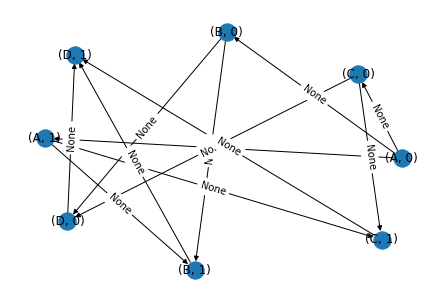

In [37]:
pos=nx.spring_layout(model)
nx.draw(model,pos,with_labels = True)
labels = nx.get_edge_attributes(model,'weight')
nx.draw_networkx_edge_labels(model,pos,edge_labels=labels)

In [38]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete.CPD import TabularCPD
student = BayesianNetwork([('diff', 'grades'), ('intel', 'grades')])
grades_cpd = TabularCPD('grades', 3, [[0.1,0.1,0.1,0.2,0.1,0.1],
                                      [0.1,0.1,0.2,0.1,0.1,0.1],
                                      [0.7,0.8,0.8,0.8,0.9,0.8]],
                        evidence=['diff', 'intel'], evidence_card=[2, 3])
student.add_cpds(grades_cpd)
student.get_cpds()[0].values

array([[[0.1, 0.1, 0.1],
        [0.2, 0.1, 0.1]],

       [[0.1, 0.1, 0.2],
        [0.1, 0.1, 0.1]],

       [[0.7, 0.8, 0.8],
        [0.8, 0.9, 0.8]]])

[<TabularCPD representing P((pull1, 0):2) at 0x2aae5a11eaf0>,
 <TabularCPD representing P((pull2, 0):2) at 0x2aae5a125f40>,
 <TabularCPD representing P((owgaze1, 0):2) at 0x2aae5a0357c0>,
 <TabularCPD representing P((owgaze2, 0):2) at 0x2aae5a11e6d0>,
 <TabularCPD representing P((pull1, 1):2 | (owgaze1, 0):2) at 0x2aae5a11e130>,
 <TabularCPD representing P((pull2, 1):2 | (owgaze2, 0):2) at 0x2aae5a11e6a0>,
 <TabularCPD representing P((owgaze1, 1):2 | (pull1, 0):2) at 0x2aae5a11e9a0>,
 <TabularCPD representing P((owgaze2, 1):2 | (pull2, 0):2) at 0x2aae5a125a60>]

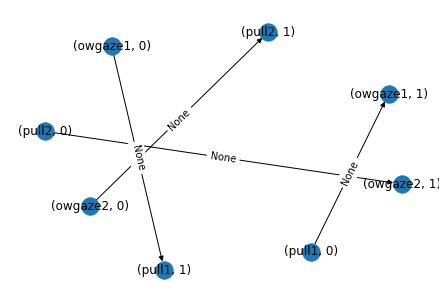

In [39]:
# real data
total_time = 720 * 2
# round to 0.5s
time_point_pull1_round = round(time_point_pull1 * 2).reset_index(drop = True).astype(int)
time_point_pull2_round  = round(time_point_pull2 * 2).reset_index(drop = True).astype(int)
time_point_onewaygaze1_round = round(pd.Series(oneway_gaze1)*2).reset_index(drop = True).astype(int)
time_point_onewaygaze2_round = round(pd.Series(oneway_gaze2)*2).reset_index(drop = True).astype(int)
time_point_mutualgaze1_round = round(pd.Series(mutual_gaze1)*2).reset_index(drop = True).astype(int)
time_point_mutualgaze2_round = round(pd.Series(mutual_gaze2)*2).reset_index(drop = True).astype(int)
# t0
pull1_t0 = np.zeros((total_time,1))
pull1_t0[np.array(time_point_pull1_round)] = 1
pull2_t0 = np.zeros((total_time,1))
pull2_t0[np.array(time_point_pull2_round)] = 1
owgaze1_t0 = np.zeros((total_time,1))
owgaze1_t0[np.array(time_point_onewaygaze1_round)] = 1
owgaze2_t0 = np.zeros((total_time,1))
owgaze2_t0[np.array(time_point_onewaygaze2_round)] = 1
mtgaze1_t0 = np.zeros((total_time,1))
mtgaze1_t0[np.array(time_point_mutualgaze1_round)] = 1
mtgaze2_t0 = np.zeros((total_time,1))
mtgaze2_t0[np.array(time_point_mutualgaze2_round)] = 1
# t1
pull1_t1 = np.zeros((total_time,1))
pull1_t1[np.array(time_point_pull1_round)+1] = 1
pull2_t1 = np.zeros((total_time,1))
pull2_t1[np.array(time_point_pull2_round)+1] = 1
owgaze1_t1 = np.zeros((total_time,1))
owgaze1_t1[np.array(time_point_onewaygaze1_round)+1] = 1
owgaze2_t1 = np.zeros((total_time,1))
owgaze2_t1[np.array(time_point_onewaygaze2_round)+1] = 1
mtgaze1_t1 = np.zeros((total_time,1))
mtgaze1_t1[np.array(time_point_mutualgaze1_round)+1] = 1
mtgaze2_t1 = np.zeros((total_time,1))
mtgaze2_t1[np.array(time_point_mutualgaze2_round)+1] = 1
## create dataframe
# data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,mtgaze1_t0,mtgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1,mtgaze1_t1,mtgaze2_t1),axis = 1)
# colnames = [("pull1",0),("pull2",0),("owgaze1",0),("owgaze2",0),("mtgaze1",0),("mtgaze2",0),("pull1",1),("pull2",1),("owgaze1",1),("owgaze2",1),("mtgaze1",1),("mtgaze2",1)]
# df = pd.DataFrame(data, columns=colnames)
data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1),axis = 1)
colnames = [("pull1",0),("pull2",0),("owgaze1",0),("owgaze2",0),("pull1",1),("pull2",1),("owgaze1",1),("owgaze2",1)]
df = pd.DataFrame(data, columns=colnames)

## built the model structure
# model = DBN(
#    [
#        (("owgaze1",0), ("pull1",1)),
#        (("owgaze1",0), ("mtgaze1",1)),
#        (("mtgaze1",0), ("pull1",1)),
#        (("pull1",0), ("owgaze1",1)),
#        (("owgaze2",0), ("pull2",1)),
#        (("owgaze2",0), ("mtgaze2",1)),
#        (("mtgaze2",0), ("pull2",1)),
#        (("pull2",0), ("owgaze2",1)),
#    ]
# )
model = DBN(
    [
        (("owgaze1",0), ("pull1",1)),
        (("pull1",0), ("owgaze1",1)),
        (("owgaze2",0), ("pull2",1)),
        (("pull2",0), ("owgaze2",1)),
    ]
)
model.fit(df)
#
pos=nx.spring_layout(model)
nx.draw(model,pos,with_labels = True)
labels = nx.get_edge_attributes(model,'weight')
nx.draw_networkx_edge_labels(model,pos,edge_labels=labels)

model.get_cpds()

In [40]:
print(model.get_cpds()[4])

+---------------+--------------------+-----------------+
| (owgaze1, 0)  | (owgaze1, 0)(0)    | (owgaze1, 0)(1) |
+---------------+--------------------+-----------------+
| (pull1, 1)(0) | 0.9744136460554371 | 1.0             |
+---------------+--------------------+-----------------+
| (pull1, 1)(1) | 0.0255863539445629 | 0.0             |
+---------------+--------------------+-----------------+


### Methods used by Alec

In [41]:
def graph_to_matrix(edges,nevents,eventnames):

    output_matrix = np.zeros((nevents,nevents)) 
    
    column = 0
    for from_layer in np.arange(0,nevents,1):
        row = 0
        #Loop through the receiving nodes (the last timeslice of each population)
        for to_layer in np.arange(0,nevents,1): 
            from_pop = eventnames[from_layer]+'_t0'
            to_pop = eventnames[to_layer]+'_t1'

            if (from_pop, to_pop) in edges:
                output_matrix[row,column] = 1
            else:
                output_matrix[row,column] = 0
            row+=1
        column+=1
                    
    return output_matrix

In [58]:
def get_weighted_dags(binaryDags,nNewBootstraps = 100):
    ### Step 1: Create Bootstraps of "discrete" DAGs for weighted DAGs
    [nTrials,frNodes,toNodes] = binaryDags.shape
    
    bootstrap_graphs = np.zeros([nNewBootstraps,nTrials,frNodes,toNodes])
    for iBootstrap in range(nNewBootstraps):
        bootstrap_graphs[iBootstrap,:,:,:] = binaryDags[np.random.randint(nTrials, size=(nTrials)),:,:]

    ### Step 2: Get Weighted DAGs
    wtd_graphs = np.nanmean(bootstrap_graphs, axis=1)
    
    return wtd_graphs

In [43]:
# clean up dataframe
data = np.concatenate((pull1_t0,pull2_t0,owgaze1_t0,owgaze2_t0,pull1_t1,pull2_t1,owgaze1_t1,owgaze2_t1),axis = 1)
colnames = ["pull1_t0","pull2_t0","owgaze1_t0","owgaze2_t0","pull1_t1","pull2_t1","owgaze1_t1","owgaze2_t1"]
eventnames = ["pull1","pull2","owgaze1","owgaze2"]
nevents = np.size(eventnames)
bhv_df = pd.DataFrame(data, columns=colnames)

# define DBN structures
all_pops = list(bhv_df.columns)
from_pops = [pop for pop in all_pops if not pop.endswith('t1')]
to_pops = [pop for pop in all_pops if pop.endswith('t1')]
causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

# train the DBN for the edges
bhv_hc = HillClimbSearch(bhv_df)
best_model = bhv_hc.estimate(max_indegree=None, white_list = causal_whitelist, scoring_method=BicScore(bhv_df))
edges = best_model.edges()
    
nFromNodes = nevents
nToNodes = nevents
nTrials = 1
DAGs = np.zeros((nTrials, nFromNodes, nToNodes))
DAGs[0,:,:] = graph_to_matrix(list(edges),nevents,eventnames)

edges


  0%|          | 0/1000000 [00:00<?, ?it/s]

OutEdgeView([('owgaze1_t0', 'owgaze1_t1'), ('owgaze2_t0', 'owgaze2_t1')])

#### methods used by Alec - separate into different "trials"

In [64]:
# every 10s (20 0.5s steps) as a "trial"
# total 720s "session" will be 72 "trials"
ntrials = 72
nFromNodes = nevents
nToNodes = nevents
for itrial in np.arange(0,ntrials,1):
    bhv_df_itrial = bhv_df.iloc[itrial*20:(itrial+1)*20]
    # define DBN structures
    all_pops = list(bhv_df_itrial.columns)
    from_pops = [pop for pop in all_pops if not pop.endswith('t1')]
    to_pops = [pop for pop in all_pops if pop.endswith('t1')]
    causal_whitelist = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]

    # train the DBN for the edges
    bhv_hc = HillClimbSearch(bhv_df_itrial)
    best_model = bhv_hc.estimate(max_indegree=None, white_list = causal_whitelist, scoring_method=BicScore(bhv_df))
    edges_itrial = best_model.edges()
    
    
    DAGs_itrial = np.zeros((ntrials, nFromNodes, nToNodes))
    DAGs_itrial[0,:,:] = graph_to_matrix(list(edges_itrial),nevents,eventnames)


weighted_graphs = get_weighted_dags(DAGs_itrial,nNewBootstraps = 1)
weighted_graphs

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

array([[[0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.06944444, 0.        ],
        [0.        , 0.        , 0.        , 0.06944444]]])

## plot behavioral results (with camera 12) and eye contact results

In [35]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_camera12[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_camera12["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_camera12[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_camera12["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_camera12[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_camera12["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_camera12[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_camera12["time_in_second"][ind_eyecontact2]

# calculate the oneway gaze or mutual gaze
animal1_gaze = np.round(np.concatenate((time_point_eyecontact1,time_point_lookatotherface1)),1)
animal1_gaze = np.unique(np.sort(animal1_gaze))
animal2_gaze = np.round(np.concatenate((time_point_eyecontact2,time_point_lookatotherface2)),1)
animal2_gaze = np.unique(np.sort(animal2_gaze))

ngaze1 = len(animal1_gaze)
ngaze2 = len(animal2_gaze)
oneway_gaze1 = []
oneway_gaze2 = []
mutual_gaze1 = []
mutual_gaze2 = []
# 
for igaze1 in np.arange(0, ngaze1, 1):
    for igaze2 in np.arange(0,ngaze2,1):
        if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
            mutual_gaze1.append(animal1_gaze[igaze1])
            mutual_gaze2.append(animal2_gaze[igaze2])
mutual_gaze1 = np.unique(mutual_gaze1)   
mutual_gaze2 = np.unique(mutual_gaze2)
oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]

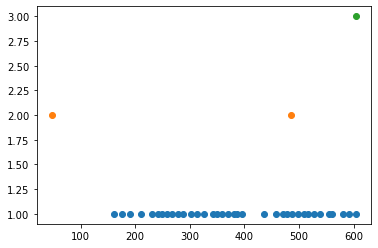

In [36]:
time_point_pull1 = np.round(time_point_pull1,2)
ind_plot = time_point_pull1 < 720
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(oneway_gaze1, np.ones(np.shape(oneway_gaze1)[0])*2,'o')
plt.plot(mutual_gaze1, np.ones(np.shape(mutual_gaze1)[0])*3,'o')

In [37]:
(time_point_eyecontact1+session_start_time)/60

array([ 1.25277778,  8.565     , 10.51833333, 10.51888889])

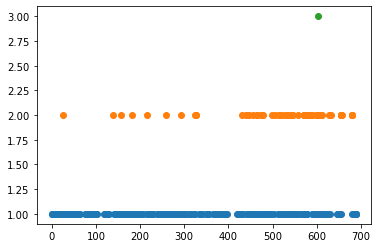

In [38]:
time_point_pull2 = np.round(time_point_pull2,2)
ind_plot = time_point_pull2 < 720
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(oneway_gaze2, np.ones(np.shape(oneway_gaze2)[0])*2,'o')
plt.plot(mutual_gaze2, np.ones(np.shape(mutual_gaze2)[0])*3,'o')

## plot behavioral results (with camera 23) and eye contact results

In [39]:
time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
ind_lookatotherface1 = np.where(np.array(look_at_face_or_not_camera23[animal1])==1)
time_point_lookatotherface1 = look_at_face_or_not_camera23["time_in_second"][ind_lookatotherface1]
ind_lookatotherface2 = np.where(np.array(look_at_face_or_not_camera23[animal2])==1)
time_point_lookatotherface2 = look_at_face_or_not_camera23["time_in_second"][ind_lookatotherface2]

ind_eyecontact1 = np.where(np.array(eye_contact_or_not_camera23[animal1])==1)
time_point_eyecontact1 = eye_contact_or_not_camera23["time_in_second"][ind_eyecontact1]
ind_eyecontact2 = np.where(np.array(eye_contact_or_not_camera23[animal2])==1)
time_point_eyecontact2 = eye_contact_or_not_camera23["time_in_second"][ind_eyecontact2]

# calculate the oneway gaze or mutual gaze
animal1_gaze = np.round(np.concatenate((time_point_eyecontact1,time_point_lookatotherface1)),1)
animal1_gaze = np.unique(np.sort(animal1_gaze))
animal2_gaze = np.round(np.concatenate((time_point_eyecontact2,time_point_lookatotherface2)),1)
animal2_gaze = np.unique(np.sort(animal2_gaze))

ngaze1 = len(animal1_gaze)
ngaze2 = len(animal2_gaze)
oneway_gaze1 = []
oneway_gaze2 = []
mutual_gaze1 = []
mutual_gaze2 = []
# 
for igaze1 in np.arange(0, ngaze1, 1):
    for igaze2 in np.arange(0,ngaze2,1):
        if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
            mutual_gaze1.append(animal1_gaze[igaze1])
            mutual_gaze2.append(animal2_gaze[igaze2])
mutual_gaze1 = np.unique(mutual_gaze1)   
mutual_gaze2 = np.unique(mutual_gaze2)
oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]

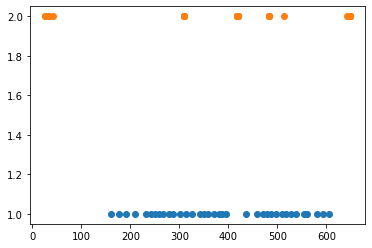

In [40]:
time_point_pull1 = np.round(time_point_pull1,2)
ind_plot = time_point_pull1 < 720
plt.plot(time_point_pull1[ind_plot], np.ones(np.shape(time_point_pull1[ind_plot])[0]),'o')
plt.plot(oneway_gaze1, np.ones(np.shape(oneway_gaze1)[0])*2,'o')
plt.plot(mutual_gaze1, np.ones(np.shape(mutual_gaze1)[0])*3,'o')

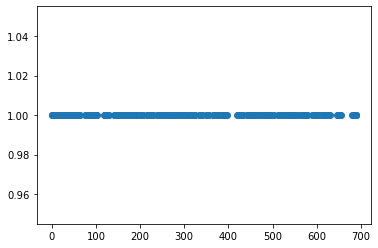

In [41]:
time_point_pull2 = np.round(time_point_pull2,2)
ind_plot = time_point_pull2 < 720
plt.plot(time_point_pull2[ind_plot], np.ones(np.shape(time_point_pull2[ind_plot])[0]),'o')
plt.plot(oneway_gaze2, np.ones(np.shape(oneway_gaze2)[0])*2,'o')
plt.plot(mutual_gaze2, np.ones(np.shape(mutual_gaze2)[0])*3,'o')